In [ ]:
! pip3 install evaluate

import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(next((root for root, _, files in os.walk("..") if "dsait4090_project_location" in files), ".."))
    print(f'Google Colab: {os.getcwd()}')
except ImportError:
    print(f'Local: {os.getcwd()}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Colab: /content/drive/Othercomputers/macbook_pro/fact-checking


In [ ]:
%load_ext autoreload
%autoreload

from src.common import get_device, read_data, OUTPUT_PATH
from src.quantemp_processor import QuantempProcessor
from src.classification_training import ClassificationTraining
from src.prediction_evaluation import calculate_f1_scores, save_predictions
from src.models.bart_large_mnli import BartLargeMnliTokenizer, BartLargeMnliClassifier

import torch
import logging
from torch import nn

MODEL = 'bart_large_mnli'
DECOMPOSITION = 'gpt3.5-turbo'

# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

logging.basicConfig(level=logging.ERROR)

device = get_device()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CUDA: 1, use NVIDIA A100-SXM4-40GB


In [ ]:
train_data = read_data(f'{DECOMPOSITION}/train_evidences_decomposed_{DECOMPOSITION}.json')
val_data = read_data(f'{DECOMPOSITION}/val_evidences_decomposed_{DECOMPOSITION}.json')
test_data = read_data(f'{DECOMPOSITION}/test_evidences_decomposed_{DECOMPOSITION}.json')

In [ ]:
%autoreload

tokenizer = BartLargeMnliTokenizer()
data_processor = QuantempProcessor(tokenizer, decomposition='decomposition')

train_dataset = data_processor.transform(train_data)
val_dataset = data_processor.transform(val_data)
test_dataset = data_processor.transform(test_data)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/9935 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/3084 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/2495 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
%autoreload

model = BartLargeMnliClassifier().to(device)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
%autoreload

training = ClassificationTraining(
    model_name=f"{MODEL}/{DECOMPOSITION}",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model=model,
    optimizer=torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8),
    loss_function=nn.CrossEntropyLoss(),
    batch_size=16,
    device=device,
    random_state=0
)

In [ ]:
%autoreload

training.start_new_training()
# training.resume_training()

Starting new training from epoch 1



EPOCH 1


train:   0%|          | 0/621 [00:00<?, ?it/s]

BartModel is using BartSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.813 | 63.44
   eval:  0.753 | 65.84
Saved checkpoint: epoch_01
Saved best model: best_model_01


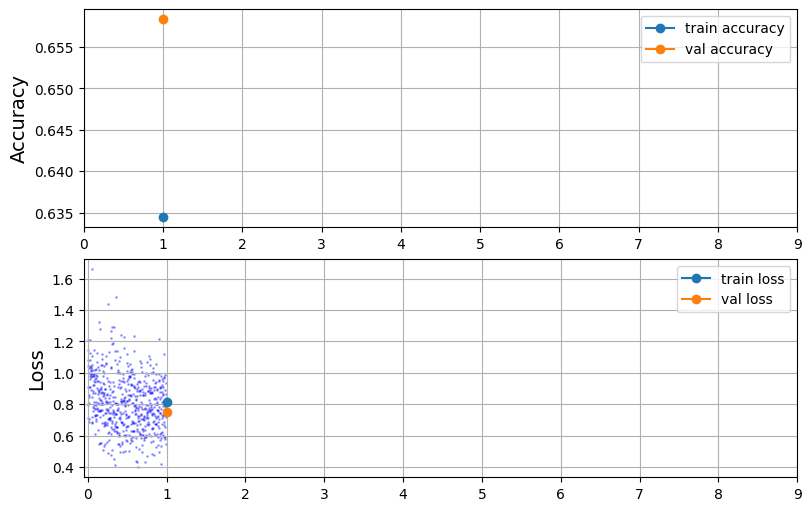


EPOCH 2


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.681 | 70.03
   eval:  0.751 | 66.20
Saved checkpoint: epoch_02
Removed: epoch_01
Saved best model: best_model_02
Removed: best_model_01


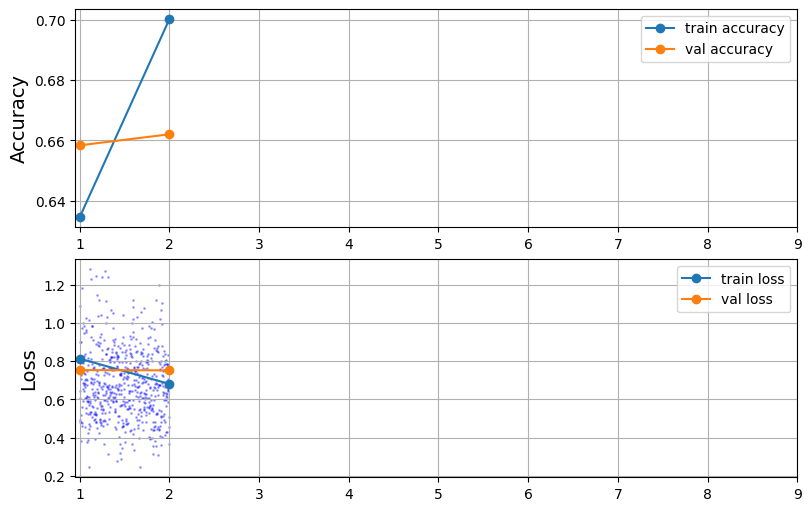


EPOCH 3


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.512 | 78.62
   eval:  0.827 | 65.71
Saved checkpoint: epoch_03
Removed: epoch_02
Early stopping counter: 1/5


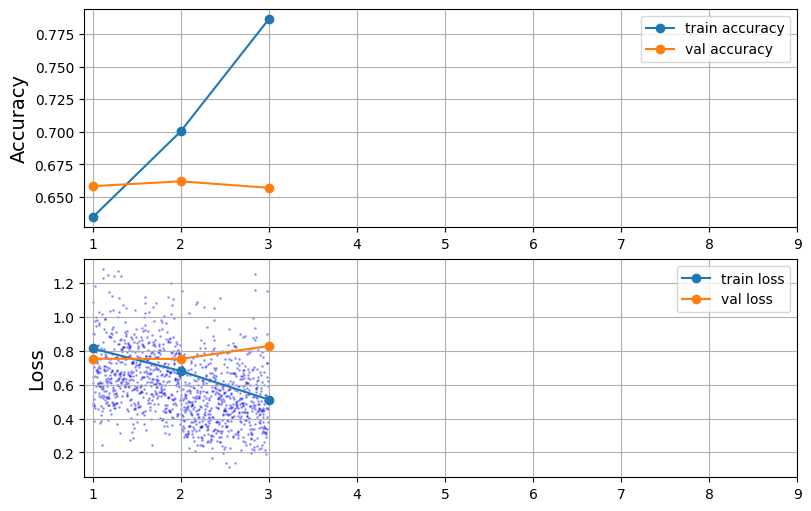

train:   0%|          | 0/621 [00:00<?, ?it/s]


EPOCH 4


val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.310 | 87.58
   eval:  1.065 | 64.03
Saved checkpoint: epoch_04
Removed: epoch_03
Early stopping counter: 2/5


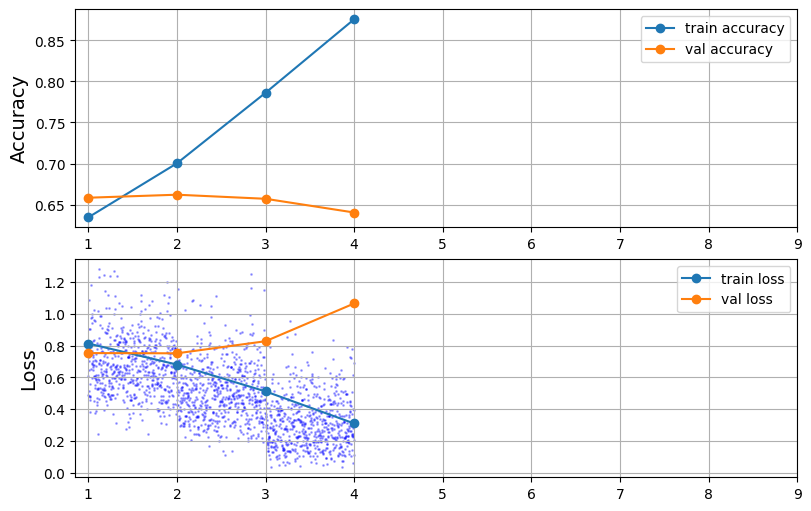


EPOCH 5


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.166 | 93.60
   eval:  1.415 | 66.09
Saved checkpoint: epoch_05
Removed: epoch_04
Early stopping counter: 3/5


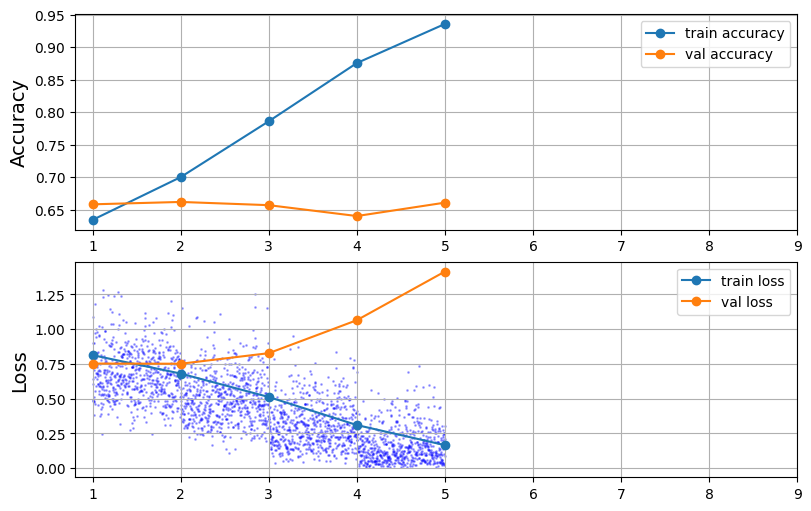

In [ ]:
%autoreload
training.train(epochs=5, patience=5)

In [1]:
training.load_best_model()

NameError: name 'training' is not defined

In [ ]:
%autoreload

test_predictions = training.evaluate_best_model(test_dataset)
calculate_f1_scores(test_data, test_predictions)

name = f'{OUTPUT_PATH}/{MODEL}_{DECOMPOSITION}.csv'
save_predictions(name, test_data, test_predictions)

  0%|          | 0/39 [00:00<?, ?it/s]

              precision    recall  f1-score   support

 Conflicting     0.4344    0.4097    0.4217       598
       False     0.7775    0.8103    0.7935      1423
        True     0.4866    0.4599    0.4729       474

    accuracy                         0.6477      2495
   macro avg     0.5662    0.5600    0.5627      2495
weighted avg     0.6400    0.6477    0.6435      2495

[[ 245  215  138]
 [ 178 1153   92]
 [ 141  115  218]]
statistical: 0.5309 0.5840
temporal: 0.6075 0.7749
interval: 0.5227 0.6490
comparison: 0.5656 0.5648

statistical temporal interval comparison per-class QuanTemp 
53.09 58.40 60.75 77.49 52.27 64.90 56.56 56.48 47.29 79.35 42.17 56.27 64.35 
Saved to output/bart_large_mnli_gpt3.5-turbo.csv
